<a href="https://colab.research.google.com/github/vg2655-wq/Data-Bootcamp-Final/blob/main/Data_Bootcamp_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tommy John Surgery Prediction

By Vaasu, Ethan, and Ben

Tommy John surgery, or UCL reconstruction, repairs the ulnar collateral ligament in the elbow, crucial for stabilizing the joint during overhead throwing, common in baseball.



In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [87]:
# Import baseball data from https://baseballsavant.mlb.com/
df = pd.read_csv('stats (5).csv')
print(df.head())
df.info()

  last_name, first_name  player_id  year  player_age  p_game   pa  k_percent  \
0        Colon, Bartolo     112526  2015          42      33  815       16.7   
1       Hawkins, LaTroy     115629  2015          42      42  162       21.0   
2           Chen, Bruce     136600  2015          38       2   35       11.4   
3           Wolf, Randy     150116  2015          38       8  161       17.4   
4        Marquis, Jason     150302  2015          36       9  216       17.1   

   bb_percent  p_era  sweet_spot_percent  ...  n_fc_formatted  n_fs_formatted  \
0         2.9   4.16                34.1  ...             NaN             NaN   
1         4.3   3.26                23.1  ...             NaN             NaN   
2         2.9  12.79                43.3  ...             NaN             NaN   
3         9.3   6.23                41.0  ...             NaN             NaN   
4         6.5   6.46                28.0  ...             NaN             NaN   

   n_kn_formatted  n_st_formatte

In [88]:
# Import Tommy John data
tj_df = pd.read_csv('tj.csv')


print(tj_df.head())

          Player TJ Surgery Date Team Level Position Throws        Country  \
0    Nic Enright      10/29/2025  CLE   MLB        P      R  United States   
1   Reed Garrett       10/8/2025  NYM   MLB        P      R  United States   
2    Luis Garcia       10/1/2025  HOU   MLB        P      R      Venezuela   
3  Shelby Miller       10/1/2025  MIL   MLB        P      R  United States   
4  Declan Cronin       9/29/2025  MIA   AAA        P      R  United States   

  High School         College(s)   Age  ...  IP  K-BB%  ERA- FIP- G.1  GS.1  \
0    Virginia      Virginia Tech  28.0  ... NaN    NaN   NaN  NaN NaN   NaN   
1    Virginia  Virginia Military  32.0  ... NaN    NaN   NaN  NaN NaN   NaN   
2         NaN                NaN  28.0  ... NaN    NaN   NaN  NaN NaN   NaN   
3       Texas                NaN  34.0  ... NaN    NaN   NaN  NaN NaN   NaN   
4    New York         Holy Cross  27.0  ... NaN    NaN   NaN  NaN NaN   NaN   

  IP.1  K-BB%.1  ERA-.1  FIP-.1  
0  NaN      NaN     Na

In [89]:
# Filter tj_df to include only players in MLB and after 1/1/2016
filtered_tj_df = tj_df[(tj_df['Level'] == 'MLB') & (pd.to_datetime(tj_df['TJ Surgery Date']) >= pd.to_datetime('2015-01-01'))].copy()

# Print the first 5 rows of the filtered DataFrame
print(filtered_tj_df.head())

# Calculate the number of players
num_players = len(filtered_tj_df)

# Print the number of players
print(f"Number of players in MLB after 1/1/2015: {num_players}")

            Player TJ Surgery Date Team Level Position Throws        Country  \
0      Nic Enright      10/29/2025  CLE   MLB        P      R  United States   
1     Reed Garrett       10/8/2025  NYM   MLB        P      R  United States   
2      Luis Garcia       10/1/2025  HOU   MLB        P      R      Venezuela   
3    Shelby Miller       10/1/2025  MIL   MLB        P      R  United States   
5  Randy Rodriguez       9/24/2025   SF   MLB        P      R      Dominican   

  High School         College(s)   Age  ...  IP  K-BB%  ERA- FIP- G.1  GS.1  \
0    Virginia      Virginia Tech  28.0  ... NaN    NaN   NaN  NaN NaN   NaN   
1    Virginia  Virginia Military  32.0  ... NaN    NaN   NaN  NaN NaN   NaN   
2         NaN                NaN  28.0  ... NaN    NaN   NaN  NaN NaN   NaN   
3       Texas                NaN  34.0  ... NaN    NaN   NaN  NaN NaN   NaN   
5         NaN                NaN  25.0  ... NaN    NaN   NaN  NaN NaN   NaN   

  IP.1  K-BB%.1  ERA-.1  FIP-.1  
0  NaN    

In [90]:
filtered_tj_df

,Player,TJ Surgery Date,Team,Level,Position,Throws,Country,High School,College(s),Age,...,IP,K-BB%,ERA-,FIP-,G.1,GS.1,IP.1,K-BB%.1,ERA-.1,FIP-.1
0,Nic Enright,10/29/2025,CLE,MLB,P,R,United States,Virginia,Virginia Tech,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Reed Garrett,10/8/2025,NYM,MLB,P,R,United States,Virginia,Virginia Military,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Luis Garcia,10/1/2025,HOU,MLB,P,R,Venezuela,NaN,NaN,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Shelby Miller,10/1/2025,MIL,MLB,P,R,United States,Texas,NaN,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Randy Rodriguez,9/24/2025,SF,MLB,P,R,Dominican,NaN,NaN,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,Josh Edgin,3/17/2015,NYM,MLB,P,L,United States,Pennsylvania,"Francis Marion, Ohio State",28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,Yu Darvish,3/17/2015,TEX,MLB,P,R,Japan,NaN,NaN,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1434,Tim Collins,3/11/2015,KC,MLB,P,L,United States,Massachusetts,NaN,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1435,Brandon Cumpton,3/10/2015,PIT,MLB,P,R,United States,Georgia,Georgia Tech,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Convert 'year' column in df to integer type
df['year'] = df['year'].astype(int)

# Convert 'TJ Surgery Date' to datetime objects and extract the year
filtered_tj_df['TJ Surgery Year'] = pd.to_datetime(filtered_tj_df['TJ Surgery Date']).dt.year

# Create an empty DataFrame to store the extracted data
df_TJ = pd.DataFrame()

# Iterate over the overlap
for player_id in filtered_tj_df['mlbamid']:
  # Find the corresponding row in df based on player_id
  player_df = df[df['player_id'] == player_id]
  # Find the corresponding row in tj_df based on player_id
  tj_player_df = filtered_tj_df[filtered_tj_df['mlbamid'] == player_id]

  # Extract rows from player_df where year is equal to the TJ Surgery year
  for _, tj_row in tj_player_df.iterrows():
    tj_year = tj_row['TJ Surgery Year']
    df_TJ = pd.concat([df_TJ, player_df[player_df['year'] == tj_year]], ignore_index=True)

# Print the first 5 rows of df_TJ
print(df_TJ.shape)
df_TJ



(184, 33)


,"last_name, first_name",player_id,year,player_age,p_game,pa,k_percent,bb_percent,p_era,sweet_spot_percent,...,n_fc_formatted,n_fs_formatted,n_kn_formatted,n_st_formatted,n_sv_formatted,n_fo_formatted,n_sc_formatted,n_fastball_formatted,n_breaking_formatted,n_offspeed_formatted
0,"Enright, Nic",663671,2025,28,27,127,23.6,9.4,2.03,32.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.4,33.5,0.2
1,"Garrett, Reed",657585,2025,32,58,238,26.9,10.9,3.90,36.1,...,28.2,22.4,NaN,21.1,NaN,NaN,NaN,56.5,21.1,22.4
2,"Garcia, Luis",677651,2025,28,2,27,25.9,0.0,3.52,15.8,...,25.5,NaN,NaN,8.5,NaN,NaN,NaN,74.5,20.8,4.7
3,"Garcia, Luis",677651,2023,26,6,115,27.0,8.7,4.00,32.9,...,43.2,NaN,NaN,12.5,NaN,NaN,NaN,74.2,20.0,5.8
4,"Miller, Shelby",571946,2025,34,48,186,29.0,8.1,2.74,36.3,...,NaN,28.8,NaN,8.4,NaN,NaN,NaN,62.1,9.1,28.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,"Santos, Sergio",435045,2015,31,14,73,24.7,9.6,4.96,41.7,...,1.2,NaN,NaN,NaN,NaN,NaN,NaN,53.8,37.2,8.9
180,"Whitley, Chase",595032,2015,26,4,84,19.0,6.0,4.19,29.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.4,34.7,22.9
181,"Bailey, Homer",456701,2015,29,2,51,5.9,7.8,5.56,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.4,15.3,28.2
182,"Ottavino, Adam",493603,2015,29,10,35,37.1,5.7,0.00,15.8,...,14.1,NaN,NaN,31.7,NaN,NaN,NaN,62.7,37.3,NaN


In [92]:
# Create a new DataFrame with only 'year' and 'player_age' columns
year_age_df = df_TJ[['year', 'player_age']].copy()

# Remove duplicate rows based on both 'year' and 'player_age' columns
unique_year_age_df = year_age_df.drop_duplicates()

# Print the resulting DataFrame
print(unique_year_age_df)


     year  player_age
0    2025          28
1    2025          32
3    2023          26
4    2025          34
5    2017          26
..    ...         ...
175  2015          27
176  2015          32
178  2015          24
179  2015          31
180  2015          26

[94 rows x 2 columns]


In [93]:
df_notTJ = df[~(df.player_id.isin(filtered_tj_df['mlbamid']))]
df_notTJ

,"last_name, first_name",player_id,year,player_age,p_game,pa,k_percent,bb_percent,p_era,sweet_spot_percent,...,n_fc_formatted,n_fs_formatted,n_kn_formatted,n_st_formatted,n_sv_formatted,n_fo_formatted,n_sc_formatted,n_fastball_formatted,n_breaking_formatted,n_offspeed_formatted
0,"Colon, Bartolo",112526,2015,42,33,815,16.7,2.9,4.16,34.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.6,10.0,7.4
1,"Hawkins, LaTroy",115629,2015,42,42,162,21.0,4.3,3.26,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.4,16.6,8.0
2,"Chen, Bruce",136600,2015,38,2,35,11.4,2.9,12.79,43.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.8,40.7,13.6
3,"Wolf, Randy",150116,2015,38,8,161,17.4,9.3,6.23,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.6,40.2,11.1
4,"Marquis, Jason",150302,2015,36,9,216,17.1,6.5,6.46,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.4,19.4,21.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8259,"Yamamoto, Yoshinobu",808967,2025,26,30,684,29.4,8.6,2.49,28.3,...,11.1,25.5,NaN,0.0,NaN,NaN,NaN,54.1,20.5,25.5
8260,"Early, Connelly",813349,2025,23,4,79,36.7,5.1,2.33,26.7,...,NaN,NaN,NaN,6.2,NaN,NaN,NaN,42.1,38.4,19.5
8261,"Farris, Mitch",815083,2025,24,5,107,22.4,10.3,6.66,49.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.9,23.5,26.7
8262,"Fermin, José",820862,2025,23,40,152,25.7,15.1,4.46,34.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.5,49.1,0.3


In [94]:
# Create a list of unique year-age pairs from df_TJ
year_age_pairs = list(zip(unique_year_age_df['year'], unique_year_age_df['player_age']))

# Create an empty DataFrame to store the matching rows from df_notTJ
df_notTJ_pair = pd.DataFrame()

# Iterate through df_notTJ and check if the year and age match any pair in year_age_pairs
for index, row in df_notTJ.iterrows():
  if (row['year'], row['player_age']) in year_age_pairs:
    df_notTJ_pair = pd.concat([df_notTJ_pair, pd.DataFrame([row])], ignore_index=True)

# Print the resulting DataFrame
print(df_notTJ_pair)

# random select 153 rows to fit the number of pitchers underwent TJ surgery
df_notTJ_pair = df_notTJ_pair.sample(n=153, random_state=123)
df_notTJ_pair

      last_name, first_name  player_id  year  player_age  p_game   pa  \
0           Francoeur, Jeff     425796  2015          31       1   11   
1             Greinke, Zack     425844  2015          31      32  843   
2              Floyd, Gavin     425856  2015          32       7   55   
3              Loewen, Adam     429400  2015          31      20   93   
4            Jackson, Edwin     429719  2015          31      47  228   
...                     ...        ...   ...         ...     ...  ...   
4498          Morales, Luis     806960  2025          22      10  199   
4499           Sasaki, Roki     808963  2025          23      10  161   
4500        Early, Connelly     813349  2025          23       4   79   
4501           Fermin, José     820862  2025          23      40  152   
4502  Ogasawara, Shinnosuke     829272  2025          27      23  173   

      k_percent  bb_percent  p_era  sweet_spot_percent  ...  n_fc_formatted  \
0           9.1        27.3   9.00          

,"last_name, first_name",player_id,year,player_age,p_game,pa,k_percent,bb_percent,p_era,sweet_spot_percent,...,n_fc_formatted,n_fs_formatted,n_kn_formatted,n_st_formatted,n_sv_formatted,n_fo_formatted,n_sc_formatted,n_fastball_formatted,n_breaking_formatted,n_offspeed_formatted
3798,"Pint, Riley",666207,2024,26,4,22,31.8,22.7,21.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4,69.6,NaN
2022,"Tinoco, Jesus",622786,2020,25,6,32,18.8,21.9,1.04,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.1,31.9,NaN
4012,"Johnson, Pierce",572955,2025,34,65,238,24.8,8.0,3.05,37.7,...,5.5,NaN,NaN,NaN,NaN,NaN,NaN,27.9,72.1,NaN
4281,"Alexander, Jason",669920,2025,32,18,336,19.3,7.7,4.77,35.1,...,1.0,NaN,NaN,16.0,NaN,NaN,NaN,51.1,16.1,32.7
2815,"Herget, Jimmy",623474,2022,28,49,266,23.7,5.6,2.48,31.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.5,61.1,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,"Gant, John",607231,2017,24,7,76,14.5,13.2,4.67,22.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.2,15.2,19.7
4212,"Beck, Tristan",663941,2025,29,31,232,17.7,6.9,4.61,34.7,...,NaN,NaN,NaN,28.4,NaN,NaN,NaN,33.0,67.0,NaN
574,"Chafin, Andrew",605177,2016,26,32,98,28.6,11.2,6.75,25.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.1,27.6,0.3
1565,"Stanek, Ryne",592773,2019,27,63,327,27.2,11.9,3.97,38.2,...,NaN,20.7,NaN,NaN,NaN,NaN,NaN,55.7,23.6,20.7


In [95]:
# Create a list of unique year-age pairs from df_TJ
year_age_pairs = list(zip(unique_year_age_df['year'], unique_year_age_df['player_age']))

# Create an empty DataFrame to store the matching rows from df_notTJ
df_notTJ_pair = pd.DataFrame()

# Iterate through df_notTJ and check if the year and age match any pair in year_age_pairs
for index, row in df_notTJ.iterrows():
  if (row['year'], row['player_age']) in year_age_pairs:
    df_notTJ_pair = pd.concat([df_notTJ_pair, pd.DataFrame([row])], ignore_index=True)

# Print the resulting DataFrame
print(df_notTJ_pair)

# random select 153 rows to fit the number of pitchers underwent TJ surgery
df_notTJ_pair = df_notTJ_pair.sample(n=153, random_state=123)
df_notTJ_pair

      last_name, first_name  player_id  year  player_age  p_game   pa  \
0           Francoeur, Jeff     425796  2015          31       1   11   
1             Greinke, Zack     425844  2015          31      32  843   
2              Floyd, Gavin     425856  2015          32       7   55   
3              Loewen, Adam     429400  2015          31      20   93   
4            Jackson, Edwin     429719  2015          31      47  228   
...                     ...        ...   ...         ...     ...  ...   
4498          Morales, Luis     806960  2025          22      10  199   
4499           Sasaki, Roki     808963  2025          23      10  161   
4500        Early, Connelly     813349  2025          23       4   79   
4501           Fermin, José     820862  2025          23      40  152   
4502  Ogasawara, Shinnosuke     829272  2025          27      23  173   

      k_percent  bb_percent  p_era  sweet_spot_percent  ...  n_fc_formatted  \
0           9.1        27.3   9.00          

,"last_name, first_name",player_id,year,player_age,p_game,pa,k_percent,bb_percent,p_era,sweet_spot_percent,...,n_fc_formatted,n_fs_formatted,n_kn_formatted,n_st_formatted,n_sv_formatted,n_fo_formatted,n_sc_formatted,n_fastball_formatted,n_breaking_formatted,n_offspeed_formatted
3798,"Pint, Riley",666207,2024,26,4,22,31.8,22.7,21.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4,69.6,NaN
2022,"Tinoco, Jesus",622786,2020,25,6,32,18.8,21.9,1.04,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.1,31.9,NaN
4012,"Johnson, Pierce",572955,2025,34,65,238,24.8,8.0,3.05,37.7,...,5.5,NaN,NaN,NaN,NaN,NaN,NaN,27.9,72.1,NaN
4281,"Alexander, Jason",669920,2025,32,18,336,19.3,7.7,4.77,35.1,...,1.0,NaN,NaN,16.0,NaN,NaN,NaN,51.1,16.1,32.7
2815,"Herget, Jimmy",623474,2022,28,49,266,23.7,5.6,2.48,31.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.5,61.1,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,"Gant, John",607231,2017,24,7,76,14.5,13.2,4.67,22.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.2,15.2,19.7
4212,"Beck, Tristan",663941,2025,29,31,232,17.7,6.9,4.61,34.7,...,NaN,NaN,NaN,28.4,NaN,NaN,NaN,33.0,67.0,NaN
574,"Chafin, Andrew",605177,2016,26,32,98,28.6,11.2,6.75,25.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.1,27.6,0.3
1565,"Stanek, Ryne",592773,2019,27,63,327,27.2,11.9,3.97,38.2,...,NaN,20.7,NaN,NaN,NaN,NaN,NaN,55.7,23.6,20.7


In [96]:
# Combined df_TJ and df
df_TJ['TJ'] = 1
df_notTJ_pair['TJ'] = 0

df_filtered = pd.concat([df_TJ, df_notTJ_pair])
print(df_filtered.columns.tolist())
df_filtered

['last_name, first_name', 'player_id', 'year', 'player_age', 'p_game', 'pa', 'k_percent', 'bb_percent', 'p_era', 'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'pitch_hand', 'n', 'n_ff_formatted', 'n_sl_formatted', 'n_ch_formatted', 'n_cu_formatted', 'n_si_formatted', 'n_fc_formatted', 'n_fs_formatted', 'n_kn_formatted', 'n_st_formatted', 'n_sv_formatted', 'n_fo_formatted', 'n_sc_formatted', 'n_fastball_formatted', 'n_breaking_formatted', 'n_offspeed_formatted', 'TJ']


,"last_name, first_name",player_id,year,player_age,p_game,pa,k_percent,bb_percent,p_era,sweet_spot_percent,...,n_fs_formatted,n_kn_formatted,n_st_formatted,n_sv_formatted,n_fo_formatted,n_sc_formatted,n_fastball_formatted,n_breaking_formatted,n_offspeed_formatted,TJ
0,"Enright, Nic",663671,2025,28,27,127,23.6,9.4,2.03,32.5,...,NaN,NaN,NaN,NaN,NaN,NaN,66.4,33.5,0.2,1
1,"Garrett, Reed",657585,2025,32,58,238,26.9,10.9,3.90,36.1,...,22.4,NaN,21.1,NaN,NaN,NaN,56.5,21.1,22.4,1
2,"Garcia, Luis",677651,2025,28,2,27,25.9,0.0,3.52,15.8,...,NaN,NaN,8.5,NaN,NaN,NaN,74.5,20.8,4.7,1
3,"Garcia, Luis",677651,2023,26,6,115,27.0,8.7,4.00,32.9,...,NaN,NaN,12.5,NaN,NaN,NaN,74.2,20.0,5.8,1
4,"Miller, Shelby",571946,2025,34,48,186,29.0,8.1,2.74,36.3,...,28.8,NaN,8.4,NaN,NaN,NaN,62.1,9.1,28.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,"Gant, John",607231,2017,24,7,76,14.5,13.2,4.67,22.2,...,NaN,NaN,NaN,NaN,NaN,NaN,65.2,15.2,19.7,0
4212,"Beck, Tristan",663941,2025,29,31,232,17.7,6.9,4.61,34.7,...,NaN,NaN,28.4,NaN,NaN,NaN,33.0,67.0,NaN,0
574,"Chafin, Andrew",605177,2016,26,32,98,28.6,11.2,6.75,25.9,...,NaN,NaN,NaN,NaN,NaN,NaN,72.1,27.6,0.3,0
1565,"Stanek, Ryne",592773,2019,27,63,327,27.2,11.9,3.97,38.2,...,20.7,NaN,NaN,NaN,NaN,NaN,55.7,23.6,20.7,0


In [97]:
# convert 'pitch_hand' in df_filtered into numbers following if ('pitch_hand' = "R") 'pitch_hand' = 1 else = 0
# Create a new column 'pitch_hand' based on 'pitch_hand'
df_filtered['pitch_hand'] = df_filtered['pitch_hand'].apply(lambda x: 1 if x == 'R' else 0)

# Display the updated DataFrame
print(df_filtered.head())

  last_name, first_name  player_id  year  player_age  p_game   pa  k_percent  \
0          Enright, Nic     663671  2025          28      27  127       23.6   
1         Garrett, Reed     657585  2025          32      58  238       26.9   
2          Garcia, Luis     677651  2025          28       2   27       25.9   
3          Garcia, Luis     677651  2023          26       6  115       27.0   
4        Miller, Shelby     571946  2025          34      48  186       29.0   

   bb_percent  p_era  sweet_spot_percent  ...  n_fs_formatted  n_kn_formatted  \
0         9.4   2.03                32.5  ...             NaN             NaN   
1        10.9   3.90                36.1  ...            22.4             NaN   
2         0.0   3.52                15.8  ...             NaN             NaN   
3         8.7   4.00                32.9  ...             NaN             NaN   
4         8.1   2.74                36.3  ...            28.8             NaN   

   n_st_formatted  n_sv_formatte

In [98]:
# replace NaN with 0 in df_filtered
df_filtered = df_filtered.replace(np.nan, 0)

In [109]:
# Get a list of all column names in df_filtered
df_filtered_columns=df_filtered.columns.values.tolist()
# Define a list of columns to be excluded from feature selection (identifiers, target variable, and specific formatted pitch types)
y=['last_name, first_name', 'player_id','year','TJ', 'n_ff_formatted', 'n_sl_formatted', 'n_ch_formatted', 'n_cu_formatted', 'n_si_formatted', 'n_fc_formatted', 'n_fs_formatted', 'n_kn_formatted', 'n_st_formatted', 'n_sv_formatted', 'n_fo_formatted', 'n_sc_formatted']
# Create a list of potential independent variables (features) by excluding the 'y' columns from all columns
X=[i for i in df_filtered_columns if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logreg = LogisticRegression()
# Initialize Recursive Feature Elimination (RFE) with Logistic Regression and a step of 20 features
rfe = RFE(logreg, step = 20)
# Fit RFE to the data to select features. 'TJ' is the target variable.
rfe = rfe.fit(df_filtered[X], df_filtered["TJ"].values.ravel())
# Print a boolean mask indicating which features were selected (True for selected, False for rejected)
print(rfe.support_)
# Print the ranking of features, where 1 indicates selected features and higher numbers indicate lower importance
print(rfe.ranking_)
# Print the list of all potential features that were considered
print(X)

[ True  True False  True  True  True False False  True  True  True False
  True False False False False False]
[1 1 2 1 1 1 2 2 1 1 1 2 1 2 2 2 2 2]
['player_age', 'p_game', 'pa', 'k_percent', 'bb_percent', 'p_era', 'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'pitch_hand', 'n', 'n_fastball_formatted', 'n_breaking_formatted', 'n_offspeed_formatted']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
# use rfe.ranking_ to filter X where removing the objects from X when rfe.ranking = 2
selected_features = [feature for i, feature in enumerate(X) if rfe.ranking_[i] == 1]
print(selected_features)


['player_age', 'p_game', 'k_percent', 'bb_percent', 'p_era', 'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed', 'swing_percent']


In [101]:
# Generate a binary logistic regression model to identify the significant contributors to "TJ"  in df_filtered

cols = selected_features
x = df_filtered[cols]
y = df_filtered['TJ']

logit_model = sm.Logit(y, x)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.552655
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: TJ               Pseudo R-squared: 0.198     
Date:               2025-12-18 23:18 AIC:              390.4898  
No. Observations:   337              BIC:              424.8705  
Df Model:           8                Log-Likelihood:   -186.24   
Df Residuals:       328              LL-Null:          -232.16   
Converged:          1.0000           LLR p-value:      1.9705e-16
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
player_age         0.0817   0.0444  1.8400 0.0658 -0.0053  0.1688
p_game            -0.0630   0.0088 -7.1178 0.0000 -0.0803 -0.0456


In [110]:
# Set features to lowest p values (most significant)
cols = ['p_game','p_era','k_percent', 'player_age']
x = df_filtered[cols]
y = df_filtered['TJ']

# Initialize and fit the Logistic Regression model using statsmodels
logit_model = sm.Logit(y, x)
result = logit_model.fit()
# Print the summary of the logistic regression model, which includes coefficients, p-values, and other statistics
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.568827
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: TJ               Pseudo R-squared: 0.174     
Date:               2025-12-18 23:38 AIC:              391.3893  
No. Observations:   337              BIC:              406.6696  
Df Model:           3                Log-Likelihood:   -191.69   
Df Residuals:       333              LL-Null:          -232.16   
Converged:          1.0000           LLR p-value:      1.9329e-17
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
p_game        -0.0583    0.0082  -7.0876  0.0000  -0.0745  -0.0422
p_era         -0.1735    0.0497  -3.4933  0.0005  -0.2708  -0.

In [112]:


x = df_filtered[cols]
y = df_filtered['TJ']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
# Initialize the Logistic Regression model
logreg = LogisticRegression()
# Fit the Logistic Regression model to the training data
logreg.fit(X_train, y_train)

LogisticRegression()

In [113]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.65


[[21 18]
 [ 6 23]]


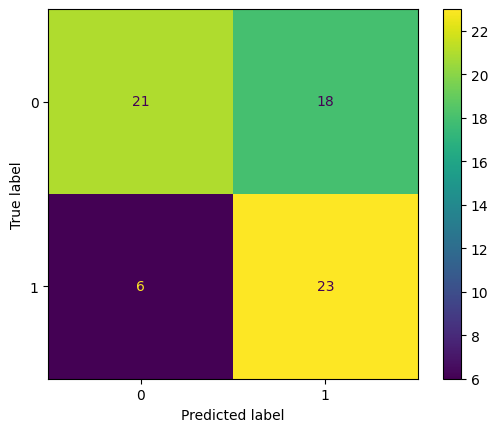

In [114]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
# Print the confusion matrix
print(cm)

# Import the ConfusionMatrixDisplay utility for visualization
from sklearn.metrics import ConfusionMatrixDisplay
# Plot the confusion matrix using the ConfusionMatrixDisplay.from_estimator method
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [115]:
# Results
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64        39
           1       0.56      0.79      0.66        29

    accuracy                           0.65        68
   macro avg       0.67      0.67      0.65        68
weighted avg       0.69      0.65      0.65        68



In [116]:
# Results
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
print(logit_roc_auc)

0.6657824933687002


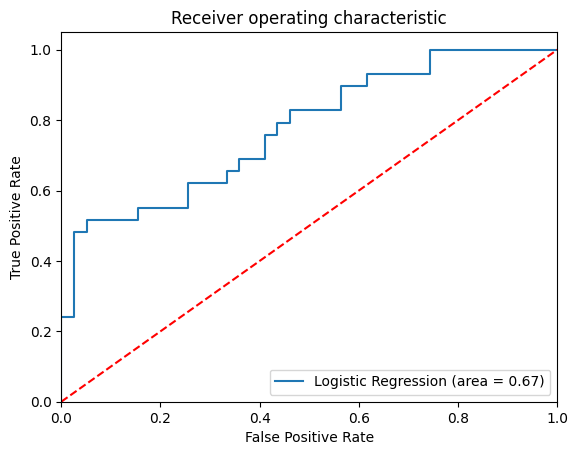

In [117]:
# Visual representation of results
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()